In [103]:
import scanpy as sc
import scarches as sca
import numpy as np
from scarches.plotting.terms_scores import plot_abs_bfs_key
import pandas as pd

In [104]:
sc.set_figure_params(figsize=(6, 6))
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb

font = {'family' : 'Arial',
        'size'   : 14}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=14)
matplotlib.rc('xtick', labelsize=14)
matplotlib.rcParams["figure.dpi"] = 200

### Pbmc Kang

In [105]:
adata = sc.read('kang_pbmc_integrated.h5ad')

In [106]:
adata.obs['condition_merged'] = adata.obs['condition'].tolist()
adata.obs['condition_merged'][adata.obs['condition_merged'].astype(str)=='nan'] = 'control'
adata.strings_to_categoricals()

C:\Users\Tamaya\AppData\Local\Temp\ipykernel_12496\3014629654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['condition_merged'][adata.obs['condition_merged'].astype(str)=='nan'] = 'control'


In [107]:
intr_cvae = sca.models.EXPIMAP.load('q_intr_cvae_nolog_alpha_kl_0_5_0_1_sd_2020', adata)

AnnData object with n_obs × n_vars = 46060 × 1972
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'INTERFERON_SIGNALING', 'SIGNALING_BY_THE_B_CELL_RECEPT', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stim', 'seurat_annotations', 'integrated_snn_res.0.5', 'seurat_clusters', 'condition', 'cell_type', 'INTERFERON_ALPHA_BETA_SIGNALIN', 'batch_join', 'cell_type_joint', 'condition_merged'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable_nbatches-0', 'highly_variable_intersection-0'
    uns: 'cell_type_joint_colors', 'condition_colors', 'neighbors', 'study_colors', 'terms', 'umap'
    obsm: 'X_cvae', 'X_umap'
    obsp: 'connectivities', 'distances'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1972 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/

c:\Users\Tamaya\OneDrive - Hogeschool Leiden\Bureaublad\bpEXA\.venv\Lib\site-packages\scarches\models\base\_base.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_

In [108]:
directions = intr_cvae.latent_directions(method="sum")

In [109]:
directions = adata.uns['directions']

In [110]:
adata.obsm['X_cvae'] *= directions[intr_cvae.model.decoder.nonzero_terms()]

In [111]:
scores_cond = intr_cvae.latent_enrich('condition_merged', comparison="control", directions_key=directions, adata=adata, n_sample=7000)

In [112]:
scores_ct = intr_cvae.latent_enrich('cell_type_joint', directions_key=directions, n_sample=7000, adata=adata)

In [113]:
scores_ct = adata.uns['bf_scores']

In [114]:
adata.uns['active_terms'] = adata.uns['directions'][intr_cvae.model.decoder.nonzero_terms()]

In [115]:
adata_ct = adata[adata.obs.cell_type_joint == 'CD14+ Monocytes']

In [116]:
scores_c_ct = intr_cvae.latent_enrich('condition_merged', comparison="control", directions_key=directions, adata=adata_ct, n_sample=10000)

c:\Users\Tamaya\OneDrive - Hogeschool Leiden\Bureaublad\bpEXA\.venv\Lib\site-packages\scarches\models\expimap\expimap_model.py:591: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = scores


In [117]:
scores_c_ct = adata.uns['bf_scores']

In [118]:
print(adata.uns.keys())

dict_keys(['cell_type_joint_colors', 'condition_colors', 'neighbors', 'study_colors', 'terms', 'umap', 'directions', 'bf_scores', 'active_terms'])


In [119]:
print('STIMULATED' in adata.obs.columns)  # Should be True if it’s in adata.obs
print('STIMULATED' in adata.uns)          # Should be True if it’s in adata.uns


False
False


In [120]:
axs = sca.plotting.plot_abs_bfs(adata, terms=adata.uns['terms'], yt_step=1, scale_y=2.45)

In [121]:
adata_ct.uns['active_terms'] = adata.uns['terms'][intr_cvae.model.decoder.nonzero_terms()]

In [122]:
def filter_set_scores(scores, adata, filter_v=2.31):
    for k in scores:
        print(k)
        mask = np.abs(scores[k]['bf']) > filter_v
        s = sum(mask)
        if s > 0:
            sort = np.argsort(np.abs(scores[k]['bf'])[mask])[::-1]
            enriched_terms = adata.uns['terms'][mask][sort]
            
            print(enriched_terms)
            print(scores[k]['bf'][mask][sort])
            
            for term in enriched_terms:
                adata.obs[term] = adata.obsm['X_cvae'][:, adata.uns['active_terms'] == term]

In [123]:
filter_set_scores(scores_c_ct, adata_ct, filter_v=1)

CD16+ Monocytes
['PLATELET_ACTIVATION_SIGNALING_' 'METABOLISM_OF_AMINO_ACIDS_AND_'
 'TRANSMEMBRANE_TRANSPORT_OF_SMA' 'SIGNALING_BY_GPCR'
 'METABOLISM_OF_NUCLEOTIDES' 'IMMUNOREGULATORY_INTERACTIONS_'
 'IMMUNE_SYSTEM' 'METABOLISM_OF_PROTEINS' 'GPCR_DOWNSTREAM_SIGNALING'
 'METABOLISM_OF_LIPIDS_AND_LIPOP' 'CELL_CYCLE_MITOTIC' 'AMYLOIDS'
 'GENERIC_TRANSCRIPTION_PATHWAY' 'INNATE_IMMUNE_SYSTEM'
 'MEMBRANE_TRAFFICKING' 'CYTOKINE_SIGNALING_IN_IMMUNE_S' 'HEMOSTASIS'
 'PROTEIN_FOLDING' 'ADAPTIVE_IMMUNE_SYSTEM' 'INTERFERON_SIGNALING'
 'NEURONAL_SYSTEM' 'DEVELOPMENTAL_BIOLOGY' 'APOPTOSIS'
 'METABOLISM_OF_VITAMINS_AND_COF' 'TRANSCRIPTION' 'AXON_GUIDANCE'
 'TOLL_RECEPTOR_CASCADES' 'SIGNALING_BY_ILS' 'MEIOSIS']
[ 2.72  2.7   2.2   2.1   1.92  1.78 -1.76 -1.72 -1.66  1.53 -1.51  1.43
 -1.42  1.4   1.38 -1.37 -1.36 -1.33  1.32 -1.27 -1.25  1.24 -1.2  -1.14
  1.11 -1.09 -1.07  1.03  1.01]
CD4+ T cells
['METABOLISM_OF_PROTEINS' 'ADAPTIVE_IMMUNE_SYSTEM' 'SIGNALING_BY_GPCR'
 'CYTOKINE_SIGNALING_IN_IMMUNE_S'

In [124]:
#check_terms = ['SIGNALING_BY_GPCR', 'CLASS_A1_RHODOPSIN_LIKE_RECEPT', 'IMMUNE_SYSTEM',
#               'RNA_POL_I_RNA_POL_III_AND_MITO', 'METABOLISM_OF_CARBOHYDRATES',
#               'CYTOKINE_SIGNALING_IN_IMMUNE_S', 'APOPTOTIC_EXECUTION_PHASE',
#               'METABOLISM_OF_NUCLEOTIDES', 'BIOLOGICAL_OXIDATIONS',
#               'INTERFERON_GAMMA_SIGNALING']

In [125]:
check_terms = ['INTERFERON_SIGNALING', 'INTERFERON_ALPHA_BETA_SIGNALIN',
 'GPCR_DOWNSTREAM_SIGNALING', 'IMMUNE_SYSTEM', 'SIGNALING_BY_GPCR',
 'METABOLISM_OF_CARBOHYDRATES', 'CYTOKINE_SIGNALING_IN_IMMUNE_S',
 'PLATELET_ACTIVATION_SIGNALING_', 'METABOLISM_OF_AMINO_ACIDS_AND_',
 'METABOLISM_OF_NUCLEOTIDES']

In [126]:
intr_cvae.term_genes('IMMUNE_SYSTEM')

c:\Users\Tamaya\OneDrive - Hogeschool Leiden\Bureaublad\bpEXA\.venv\Lib\site-packages\scarches\models\expimap\expimap_model.py:364: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result['in_mask'][in_mask] = True


genes   weights  in_mask
0    PIK3R3  1.507812     True
1      IRS1  1.307938     True
2     KIF3C  1.303473     True
3     KIF11  1.199477     True
4     IL5RA  1.180287     True
..      ...       ...      ...
486  UBE2Q2 -0.004464     True
487    UBA6 -0.004321     True
488    EEA1 -0.001604     True
489     LYN -0.001006     True
490    TAB2  0.000471     True

[491 rows x 3 columns]

In [127]:
idxs = [adata_ct.uns['active_terms'].tolist().index(t) for t in check_terms]

In [128]:
idxs

[196, 195, 134, 225, 91, 208, 230, 242, 77, 113]

In [129]:
adata_pl = sc.AnnData(X=adata.obsm['X_cvae'][:, idxs])

In [130]:
adata_pl.var_names = check_terms

In [131]:
adata_pl.obs['ct_cond'] = 'stub'

In [132]:
for i in range(adata.n_obs):
    adata_pl.obs['ct_cond'][i] = adata.obs['cell_type_joint'][i] + '_' + adata.obs['condition_merged'][i]

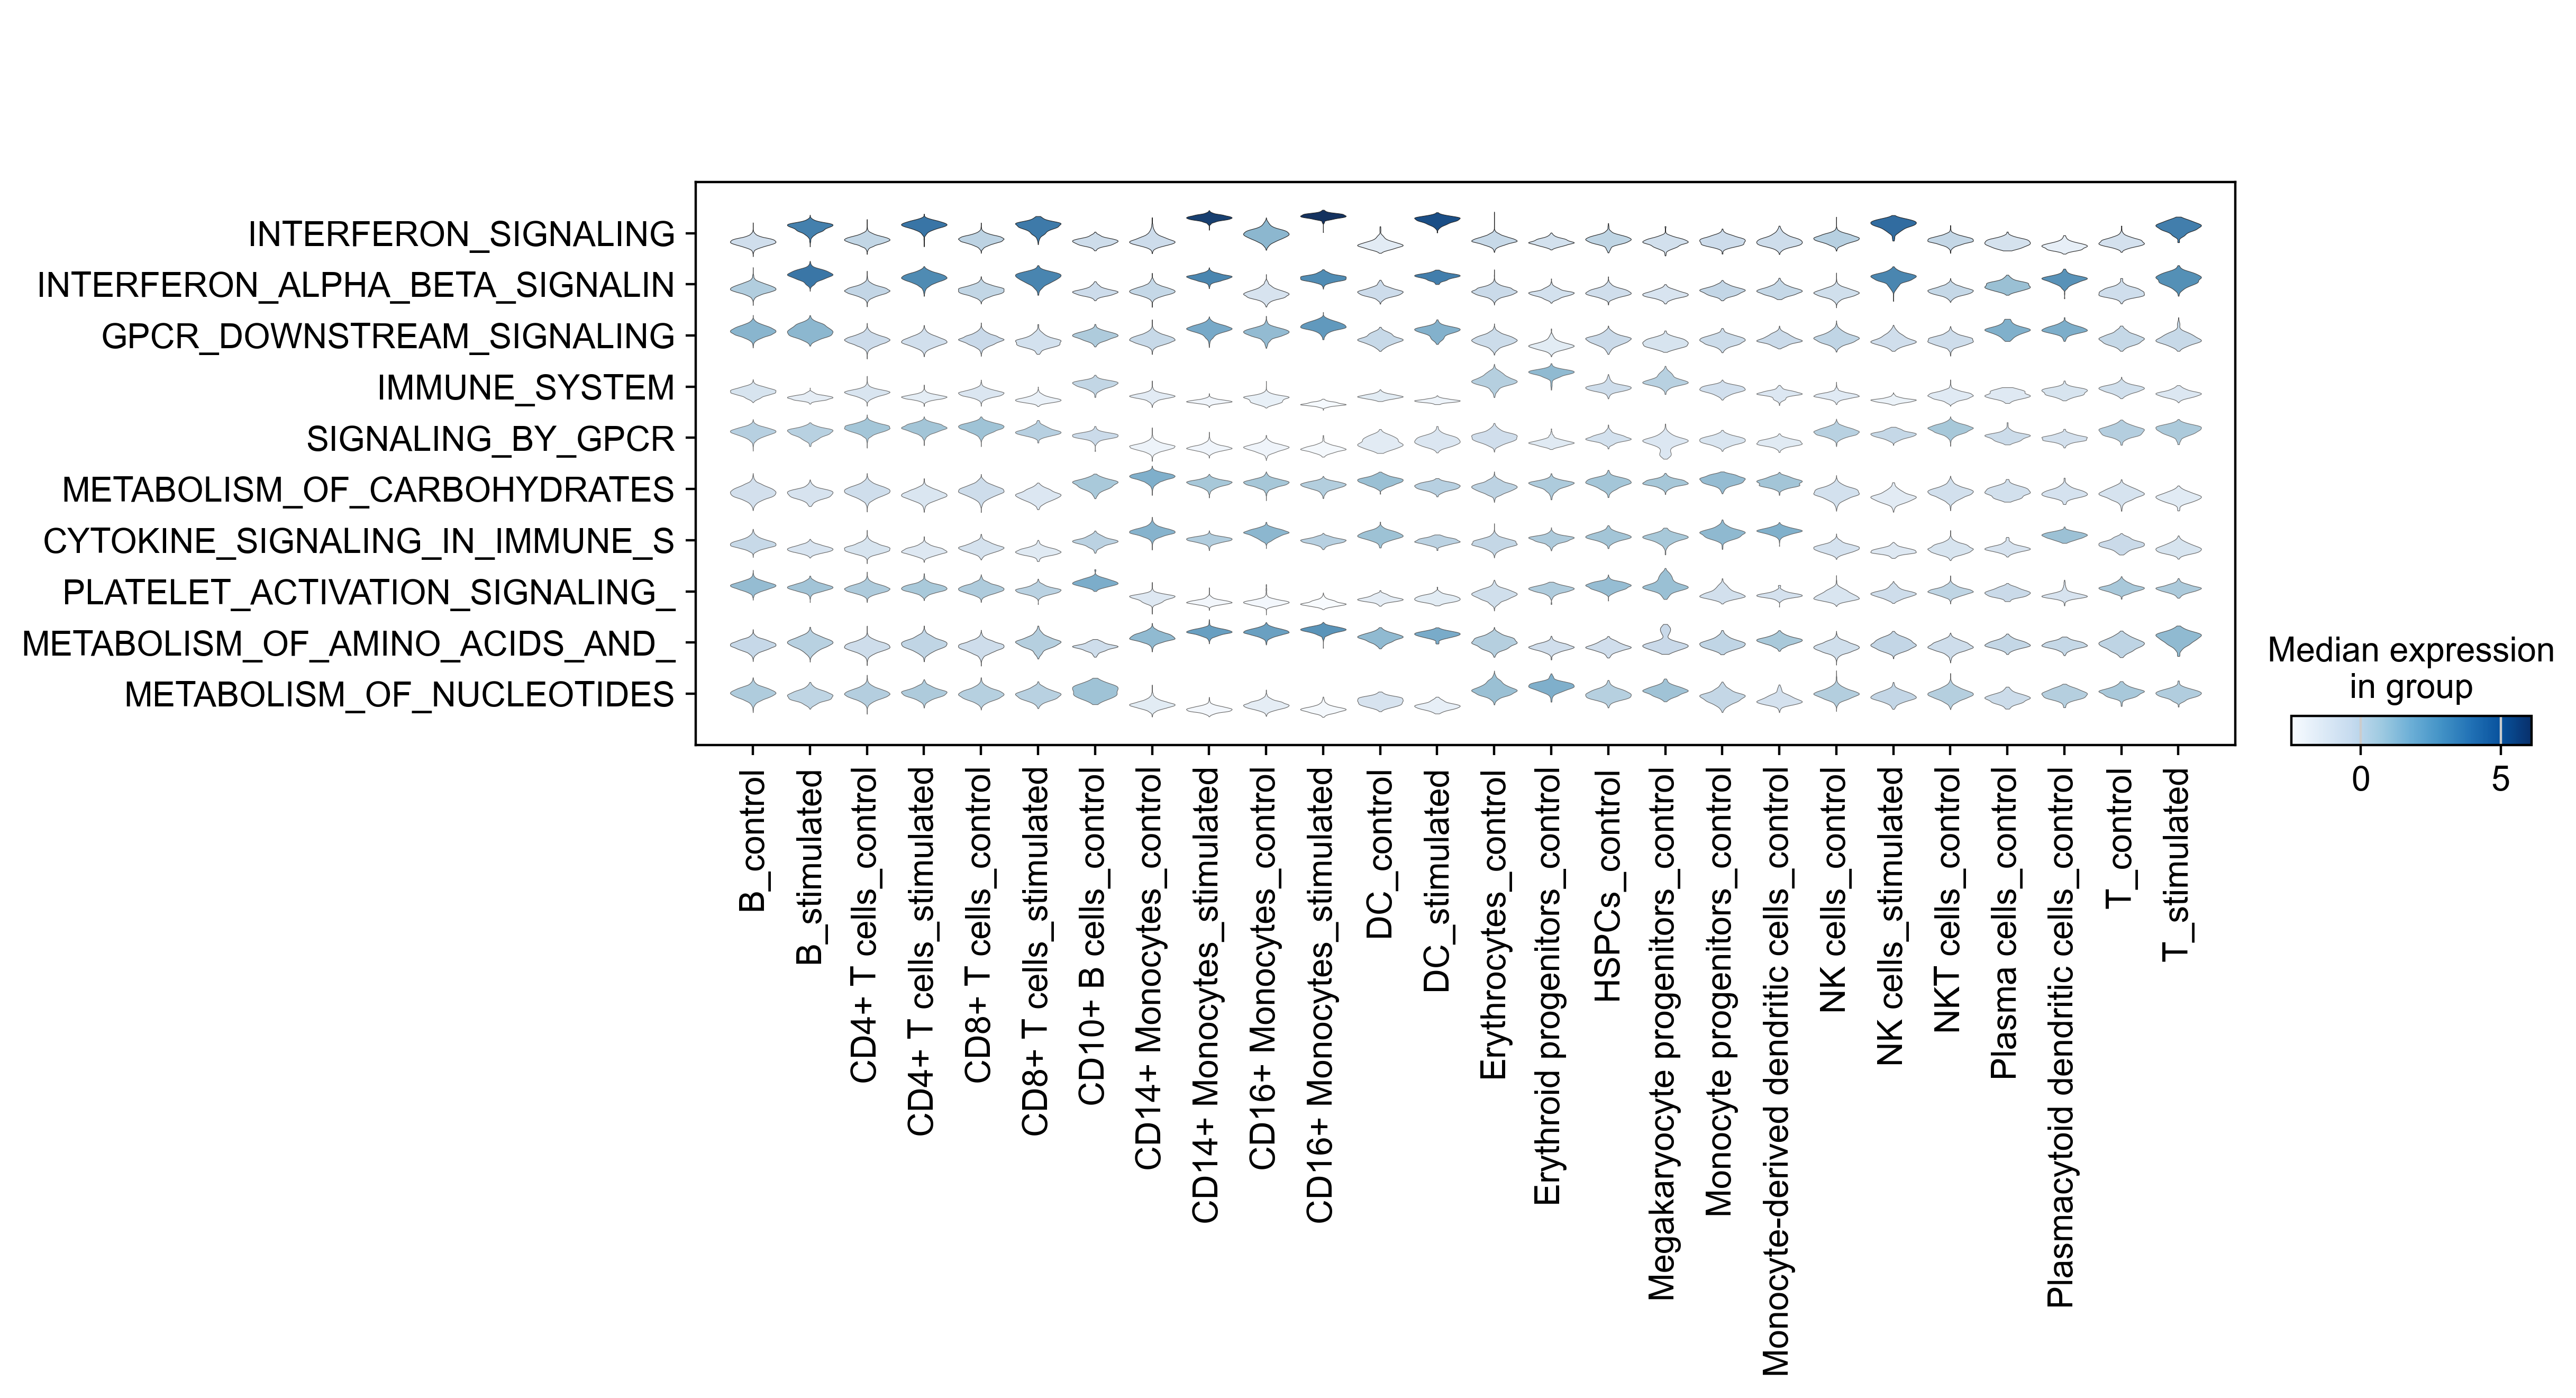

In [133]:
sc.pl.stacked_violin(adata_pl, var_names=check_terms, groupby='ct_cond', swap_axes=True)

In [134]:
query_ct = adata_pl[adata.obs.study == 'Kang'].obs.ct_cond.unique().tolist()

In [135]:
adata_pl_q = adata_pl[adata_pl.obs.ct_cond.isin(query_ct)]

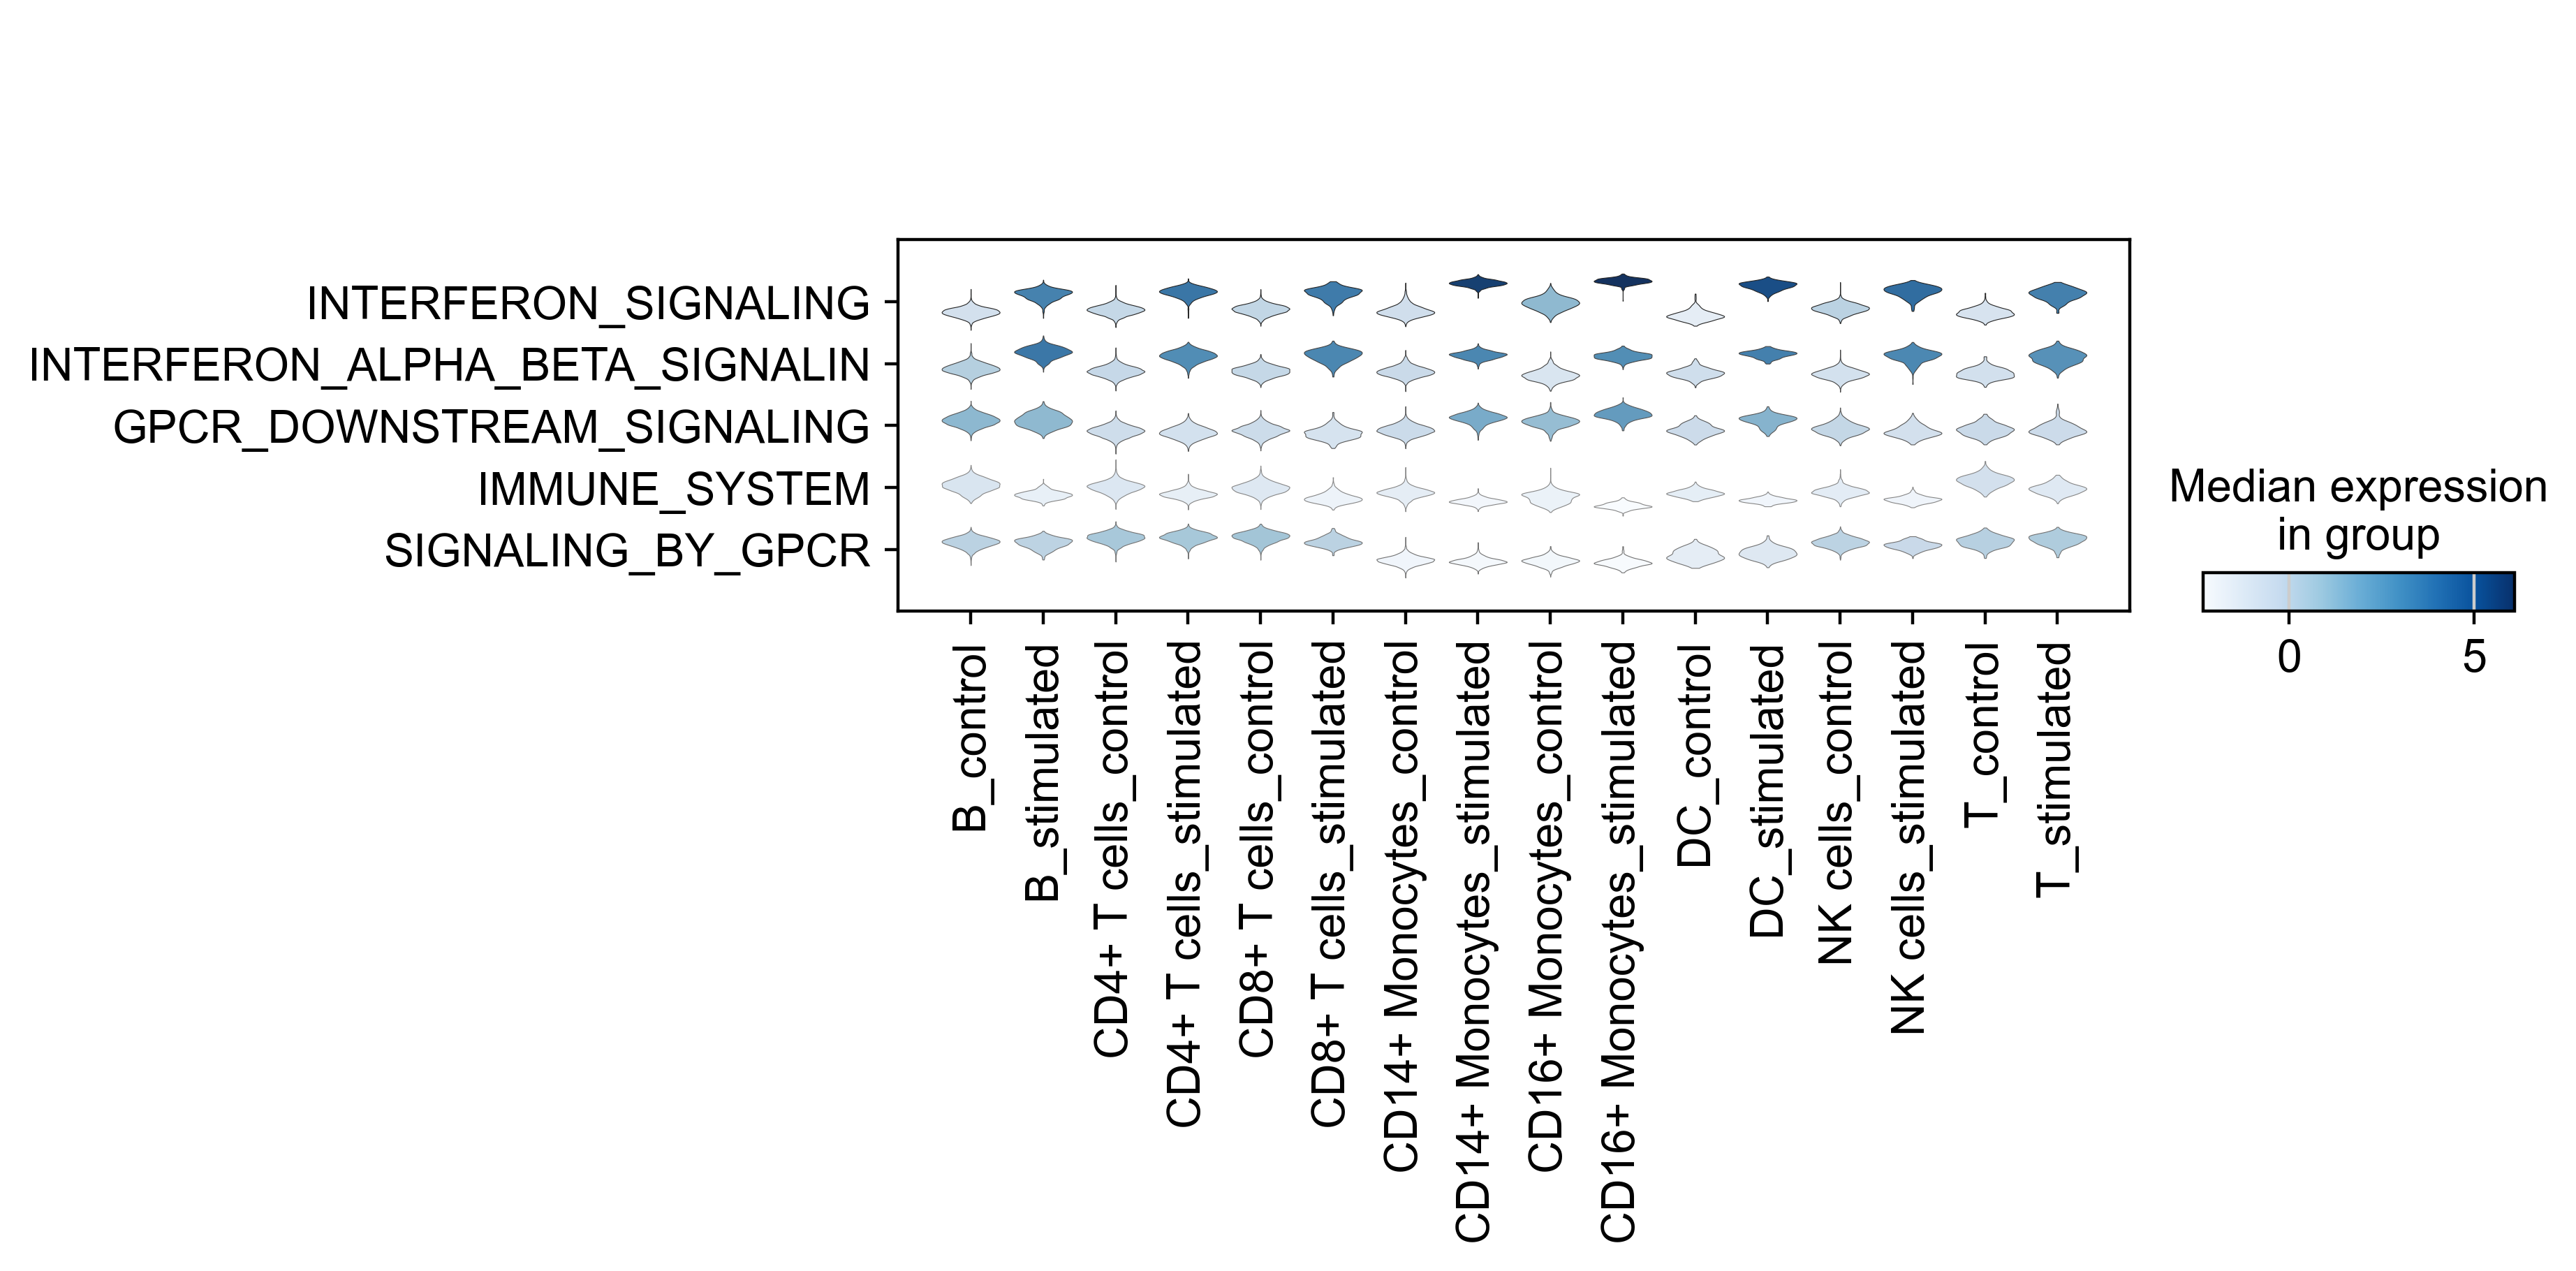

In [136]:
sc.pl.stacked_violin(adata_pl_q, var_names=check_terms[:5], groupby='ct_cond', swap_axes=True)

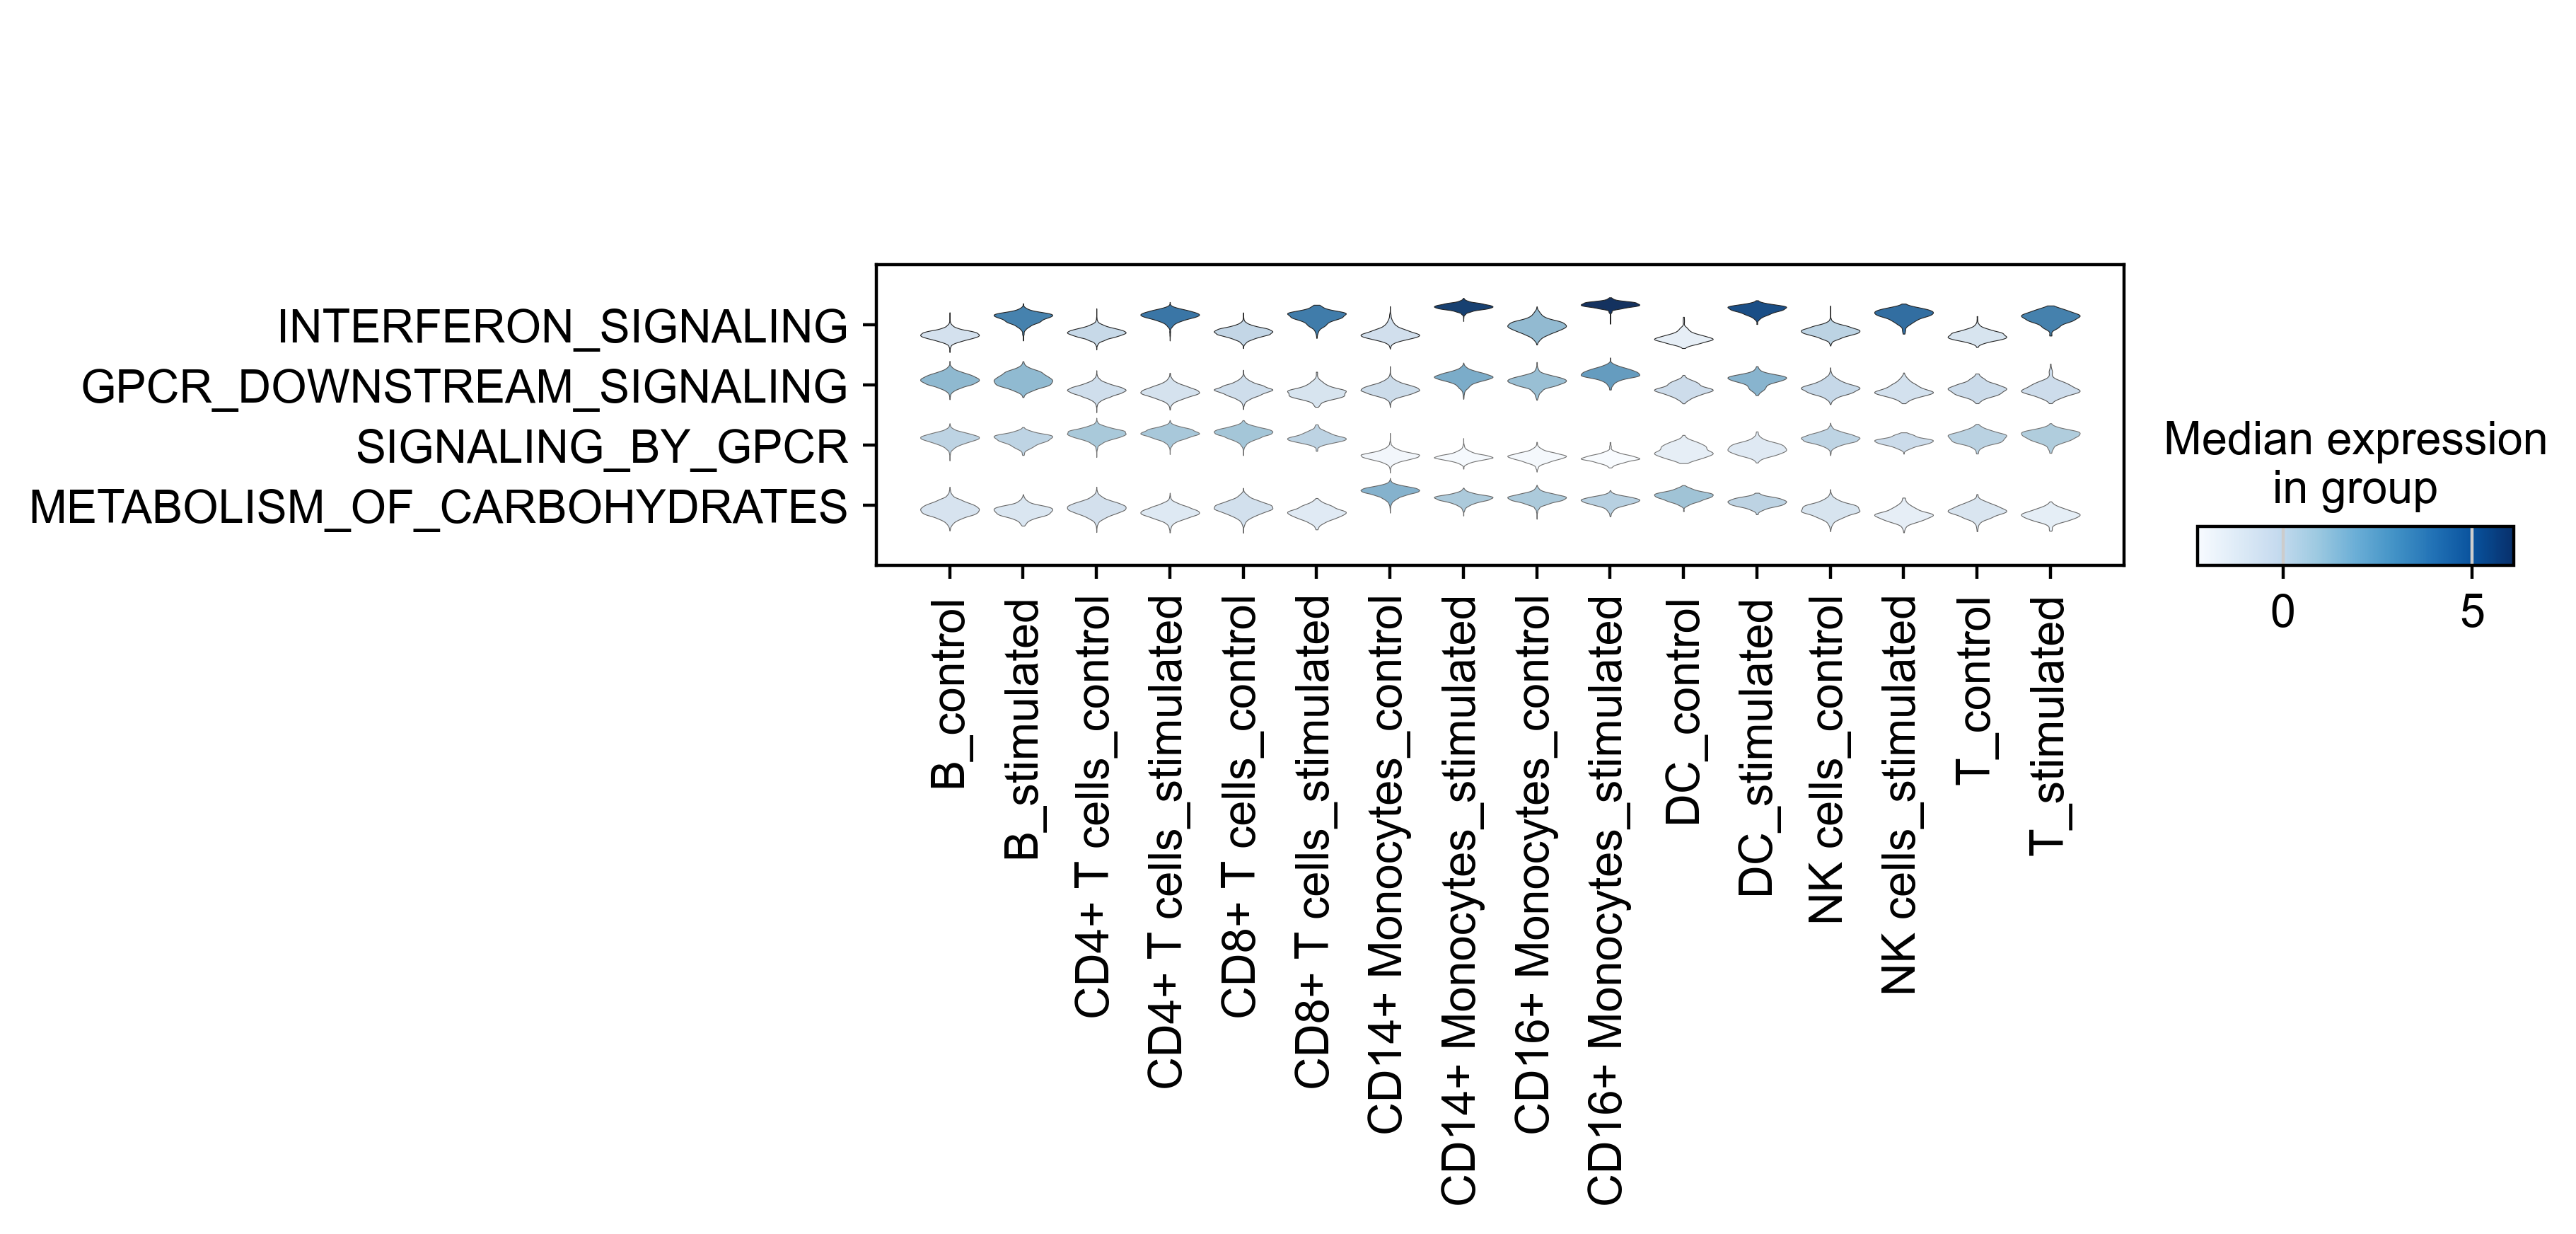

In [137]:
sc.pl.stacked_violin(adata_pl_q, var_names=['INTERFERON_SIGNALING', 'GPCR_DOWNSTREAM_SIGNALING', 'SIGNALING_BY_GPCR', 'METABOLISM_OF_CARBOHYDRATES'], groupby='ct_cond', swap_axes=True)

In [138]:
query_ct = adata.obs.cell_type_joint[adata.obs.batch_join == 'Kang (query)'].unique()

In [139]:
scores_ct_q = {k: v for k, v in scores_ct.items() if k in query_ct.categories}

In [140]:
for ct in query_ct.categories:
    print(ct)
print(adata.uns.keys())

B
CD4+ T cells
CD8+ T cells
CD10+ B cells
CD14+ Monocytes
CD16+ Monocytes
DC
Erythrocytes
Erythroid progenitors
HSPCs
Megakaryocyte progenitors
Monocyte progenitors
Monocyte-derived dendritic cells
NK cells
NKT cells
Plasma cells
Plasmacytoid dendritic cells
T
dict_keys(['cell_type_joint_colors', 'condition_colors', 'neighbors', 'study_colors', 'terms', 'umap', 'directions', 'bf_scores', 'active_terms'])


In [141]:
!pip show scArches

Name: scArches
Version: 0.6.1
Summary: Transfer learning with Architecture Surgery on Single-cell data
Home-page: https://github.com/theislab/scarches
Author: 
Author-email: 
License: MIT
Location: c:\Users\Tamaya\OneDrive - Hogeschool Leiden\Bureaublad\bpEXA\.venv\Lib\site-packages
Requires: anndata, gdown, h5py, leidenalg, matplotlib, muon, numpy, pandas, requests, scanpy, scHPL, scikit-learn, scipy, scvi-tools, torch, tqdm
Required-by: 


In [142]:
adata_pl.obs['ct_cond'] = [
    adata.obs['cell_type_joint'][i] + '_' + adata.obs['condition_merged'][i] 
    for i in range(adata.n_obs)
]

In [146]:
query_ct

[], Categories (18, object): ['B', 'CD4+ T cells', 'CD8+ T cells', 'CD10+ B cells', ..., 'NKT cells', 'Plasma cells', 'Plasmacytoid dendritic cells', 'T']

In [158]:
for ct in query_ct.categories:
    print(ct)
    scores = scores_ct[ct]['bf']
    sort = np.argsort(np.abs(scores))[::-1]
    top_10_terms = adata.uns['directions'][sort][:10]
    idxs = [adata.uns['active_terms'].tolist().index(t) for t in top_10_terms]
    
    adata_pl = sc.AnnData(X=adata.obsm['X_cvae'][:, idxs])
    adata_pl.var_names = top_10_terms.tolist()
    adata_pl.obs['ct_cond'] = 'stub'
    for i in range(adata.n_obs):
        adata_pl.obs['ct_cond'][i] = adata.obs['cell_type_joint'][i] + '_' + adata.obs['condition_merged'][i]
        break
    # query_typs = adata_pl[adata.obs.study == 'Kang'].obs.ct_cond.unique().tolist()
    # adata_pl_q = adata_pl[adata_pl.obs()]
    adata_pl = adata_pl.cd_cond.unique()
    sc.pl.stacked_violin(adata_pl, var_names=top_10_terms, groupby='ct_cond', swap_axes=True)

B


c:\Users\Tamaya\OneDrive - Hogeschool Leiden\Bureaublad\bpEXA\.venv\Lib\site-packages\anndata\_core\anndata.py:844: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    [-1.0, -1.0, 1.0, -1.0, -1.0]

    Inferred to be: floating

  names = self._prep_dim_index(names, "var")


AttributeError: 'AnnData' object has no attribute 'cd_cond'

In [ ]:
adata.obs['condition_merged'] = adata.obs['condition_merged'].astype(str)
adata.obs['condition_merged'][adata.obs['condition_merged']=='stimulated'] = 'IFN-beta'

C:\Users\Tamaya\AppData\Local\Temp\ipykernel_12496\3298277474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs['condition_merged'][adata.obs['condition_merged']=='stimulated'] = 'IFN-beta'


In [ ]:
for ct in query_ct:
    print(ct)
    adata_ct = adata[adata.obs.cell_type_joint == ct]
    scores_c_ct = intr_cvae.latent_enrich('condition_merged', comparison="control", directions=directions, adata=adata_ct, n_perm=50000, exact=True)
    
    scores = scores_c_ct['IFN-beta']['bf']
    sort = np.argsort(np.abs(scores))[::-1]
    top_10_terms = adata.uns['full_terms'][sort][:10]
    idxs = [adata.uns['active_terms'].tolist().index(t) for t in top_10_terms]
    
    adata_pl = sc.AnnData(X=adata.obsm['X_cvae'][:, idxs])
    terms = [t[:45] for t in top_10_terms]
    adata_pl.var_names = terms
    adata_pl.obs['ct_cond'] = 'stub'
    for i in range(adata.n_obs):
        adata_pl.obs['ct_cond'][i] = adata.obs['cell_type_joint'][i] + '_' + adata.obs['condition_merged'][i]
    query_typs = adata_pl[adata.obs.study == 'Kang'].obs.ct_cond.unique().tolist()
    adata_pl_q = adata_pl[adata_pl.obs.ct_cond.isin(query_typs)]
    sc.pl.stacked_violin(adata_pl_q, var_names=terms, groupby='ct_cond', swap_axes=True)